In [1]:
import dataclasses
import functools

import jax
from jax import numpy as jnp
import numpy as np

from flax import linen
from flax import struct
import optax
from tensorflow_probability.substrates import jax as tfp

tfb = tfp.bijectors
tfd = tfp.distributions

from dm_control import suite
from matplotlib import pylab as plt

import daves_rl_lib
from daves_rl_lib import networks
from daves_rl_lib.algorithms import deep_q_network
from daves_rl_lib.environments import dm_control_environment
from daves_rl_lib.environments import environment_lib
from daves_rl_lib.internal import video_util

video_util.initialize_virtual_display()

/home/davmre/rl/.venv/lib/python3.8/site-packages/glfw/__init__.py:906: GLFWError: (65544) b'X11: The DISPLAY environment variable is missing'
  warnings.warn(message, GLFWError)


Initialized virtual display.


In [2]:
buffer_size = 2048
epsilon = optax.exponential_decay(
    init_value=0.9,
    transition_steps=2000,
    decay_rate=0.1,
    end_value=1e-3)
discount_factor = 0.999
learning_rate = optax.piecewise_constant_schedule(
    init_value=0.01,
    boundaries_and_scales={2000: 0.5, 5000: 0.5, 10000: 0.5, 15000: 0.5})
gradient_batch_size = 32
target_weights_decay = 0.99

In [18]:
def vector_from_categorical(action):
    return jnp.float32(action[..., None] * 2. - 1.)

env = dm_control_environment.DMControlEnvironment(
    suite.load('cartpole', task_name='balance'),
    discount_factor=discount_factor,
    action_transform_fn=vector_from_categorical,
    action_space=environment_lib.ActionSpace(num_actions=2),
    max_episode_length=200)


In [19]:
env._dm_env.action_spec()

BoundedArray(shape=(1,), dtype=dtype('float64'), name=None, minimum=[-1.], maximum=[1.])

In [20]:


agent = deep_q_network.DQNAgent(
    qvalue_net=networks.make_model([24, 24, 2],
                                   obs_size=env.observation_size),
    qvalue_optimizer=optax.adam(learning_rate),
    replay_buffer_size=buffer_size,
    target_weights_decay=target_weights_decay,
    gradient_batch_size=gradient_batch_size,
    discount_factor=discount_factor,
    epsilon=epsilon)

In [21]:
seed = jax.random.PRNGKey(0)
seed, weights_init_seed, state_init_seed = jax.random.split(seed, 3)

state = env.reset(seed=state_init_seed)
initial_state_observation = state.observation

weights = agent.init_weights(seed=weights_init_seed,
                             dummy_observation=state.observation,
                             dummy_action=env.action_space.dummy_action())

In [22]:
agent.qvalue_net.apply(weights.qvalue_weights, state.observation)

d = agent.action_dist(weights, state.observation)

In [23]:
import time

select_action = jax.jit(
    lambda w, obs, s: agent.action_dist(w, obs).sample(seed=s))
update = jax.jit(agent.update)

In [24]:

durations = []
returns = []

for episode in range(100):
    seed, state_init_seed = jax.random.split(seed, 2)
    state = env.reset(seed=state_init_seed)
    t0 = time.time()
    num_steps = 0
    while not state.done:
        seed, action_seed, env_seed = jax.random.split(seed, 3)
        action = select_action(weights, state.observation, action_seed)
        next_state = env.step(action)
        weights = update(weights,
                         transition=environment_lib.Transition(
                            observation=state.observation,
                            action=action,
                            next_observation=next_state.observation,
                            reward=next_state.reward,
                            done=next_state.done)
                        )
        state = next_state
        num_steps += 1
    print(f"Finished episode {episode} of length {num_steps} in {time.time() - t0 : .2f}s with return {state.episode_return}.")
    durations.append(num_steps)
    returns.append(state.episode_return)


Finished episode 0 of length 200 in  3.15s with return 89.53146362304688.
Finished episode 1 of length 200 in  1.97s with return 92.10225677490234.
Finished episode 2 of length 200 in  1.99s with return 95.24983215332031.
Finished episode 3 of length 200 in  1.83s with return 94.43358612060547.
Finished episode 4 of length 200 in  1.75s with return 118.93509674072266.
Finished episode 5 of length 200 in  1.75s with return 94.30689239501953.
Finished episode 6 of length 200 in  1.91s with return 130.90342712402344.
Finished episode 7 of length 200 in  2.01s with return 108.82194519042969.
Finished episode 8 of length 200 in  1.78s with return 110.31379699707031.
Finished episode 9 of length 200 in  1.79s with return 135.8825225830078.
Finished episode 10 of length 200 in  2.00s with return 122.62732696533203.
Finished episode 11 of length 200 in  1.97s with return 130.11415100097656.
Finished episode 12 of length 200 in  1.76s with return 100.26620483398438.
Finished episode 13 of lengt

Text(0.5, 1.0, 'Episode returns')

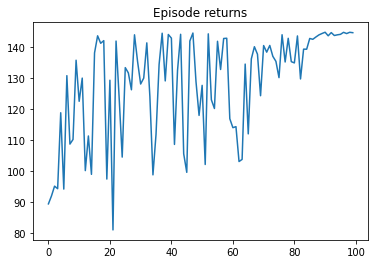

In [25]:
plt.plot(returns)
plt.title('Episode returns')

In [26]:
print("Estimated value", agent._qvalue_net.apply(weights.qvalue_weights, initial_state_observation))


Estimated value [139.31062 138.74718]
